In [56]:
import pandas as pd
from collections import Counter

In [57]:
df = pd.read_csv("outputs/output_ABC.csv")

# Use eval to convert stringified Python objects back into lists/dicts
df["A_raw_entities"] = df["A_raw_entities"].apply(eval)
df["B_raw_entities"] = df["B_raw_entities"].apply(eval)
df["C_raw_entities"] = df["C_raw_entities"].apply(eval)

df.head(3)

,statement,label,label_binary,A_raw_entities,B_raw_entities,C_raw_entities
0,"90 percent of Americans ""support universal bac...",5,1,"[{'entity': 'MISC', 'score': 0.99866974, 'inde...","[{'entity': 'I-MISC', 'score': 0.99725264, 'in...","[{'entity': 'LABEL_1', 'score': 0.56547683, 'i..."
1,Last year was one of the deadliest years ever ...,1,0,[],[],"[{'entity': 'LABEL_0', 'score': 0.59776855, 'i..."
2,"Bernie Sanders's plan is ""to raise your taxes ...",0,0,"[{'entity': 'PER', 'score': 0.9983652, 'index'...","[{'entity': 'I-PER', 'score': 0.9991854, 'inde...","[{'entity': 'LABEL_1', 'score': 0.53581613, 'i..."


In [58]:
def A_clean_entities(entity_list):
    '''To extract entity name and tag + remove special character'''
    cleaned_list = []
    for entity in entity_list:
        cleaned_entity = {
            'word': entity['word'].lstrip('Ġ'),  
            'entity': entity['entity']
        }
        cleaned_list.append(cleaned_entity)
    return cleaned_list

def B_clean_and_merge_entities(entity_list):
    '''To extract entity name and tag + merge separated entities'''
    cleaned_list = []
    current_entity = None

    for entity in entity_list:
        word = entity['word']
        entity_type = entity['entity']

        if word.startswith("##"):
            # Merge subwords with the previous entity if it exists
            if current_entity:
                current_entity['word'] += word.replace("##", "")
        else:
            # Save the previous entity and start a new one
            if current_entity:
                cleaned_list.append(current_entity)
            current_entity = {'word': word, 'entity': entity_type}

    # Append the last entity
    if current_entity:
        cleaned_list.append(current_entity)

    return cleaned_list




# Apply function to create the new column
df["A_clean_entities"] = df["A_raw_entities"].apply(A_clean_entities)
df["B_clean_entities"] = df["B_raw_entities"].apply(B_clean_and_merge_entities)

In [59]:
df.head(3)

,statement,label,label_binary,A_raw_entities,B_raw_entities,C_raw_entities,A_clean_entities,B_clean_entities
0,"90 percent of Americans ""support universal bac...",5,1,"[{'entity': 'MISC', 'score': 0.99866974, 'inde...","[{'entity': 'I-MISC', 'score': 0.99725264, 'in...","[{'entity': 'LABEL_1', 'score': 0.56547683, 'i...","[{'word': 'Americans', 'entity': 'MISC'}]","[{'word': 'Americans', 'entity': 'I-MISC'}]"
1,Last year was one of the deadliest years ever ...,1,0,[],[],"[{'entity': 'LABEL_0', 'score': 0.59776855, 'i...",[],[]
2,"Bernie Sanders's plan is ""to raise your taxes ...",0,0,"[{'entity': 'PER', 'score': 0.9983652, 'index'...","[{'entity': 'I-PER', 'score': 0.9991854, 'inde...","[{'entity': 'LABEL_1', 'score': 0.53581613, 'i...","[{'word': 'Bernie', 'entity': 'PER'}, {'word':...","[{'word': 'Bernie', 'entity': 'I-PER'}, {'word..."


In [60]:
# Separate into true and false dataframe
df_true = df[df['label_binary'] == 1] 
df_false = df[df['label_binary'] == 0] 

In [61]:
df_true.head(3)

,statement,label,label_binary,A_raw_entities,B_raw_entities,C_raw_entities,A_clean_entities,B_clean_entities
0,"90 percent of Americans ""support universal bac...",5,1,"[{'entity': 'MISC', 'score': 0.99866974, 'inde...","[{'entity': 'I-MISC', 'score': 0.99725264, 'in...","[{'entity': 'LABEL_1', 'score': 0.56547683, 'i...","[{'word': 'Americans', 'entity': 'MISC'}]","[{'word': 'Americans', 'entity': 'I-MISC'}]"
3,Voter ID is supported by an overwhelming major...,4,1,"[{'entity': 'MISC', 'score': 0.91534454, 'inde...","[{'entity': 'I-MISC', 'score': 0.9819614, 'ind...","[{'entity': 'LABEL_1', 'score': 0.5577408, 'in...","[{'word': 'NY', 'entity': 'MISC'}, {'word': 'e...","[{'word': 'ID', 'entity': 'I-MISC'}, {'word': ..."
7,One in three women is sexually assaulted on th...,3,1,[],[],"[{'entity': 'LABEL_0', 'score': 0.5470952, 'in...",[],[]


In [62]:
def count_word_entities(df, column_name):
    '''Extract '''
    word_entity_pairs = []
    
    # Extract all (word, entity) pairs
    for row in df[column_name]:
        for item in row:
            word_entity_pairs.append((item['word'], item['entity']))
    
    # Count occurrences
    counter = Counter(word_entity_pairs)
    
    # Convert to DataFrame
    result_df = pd.DataFrame(counter.items(), columns=['word_entity', 'count'])

    # Split 'word_entity' into separate 'word' and 'entity' columns
    result_df[['word', 'entity']] = pd.DataFrame(result_df['word_entity'].tolist(), index=result_df.index)
    result_df.drop(columns=['word_entity'], inplace=True)

    # Sort by count descending
    return result_df.sort_values(by='count', ascending=False)

In [63]:

A_true_results = count_word_entities(df_true, 'A_clean_entities')
A_false_results = count_word_entities(df_false, 'A_clean_entities')

B_true_results = count_word_entities(df_true, 'B_clean_entities')
B_false_results = count_word_entities(df_false, 'B_clean_entities')

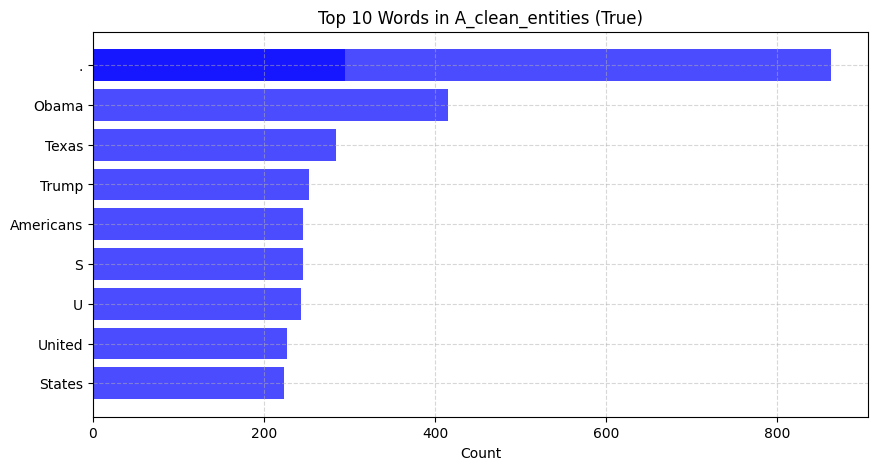

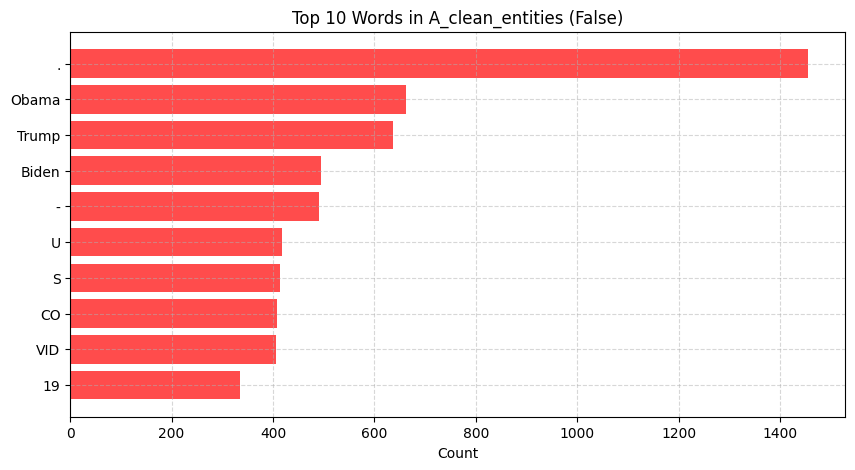

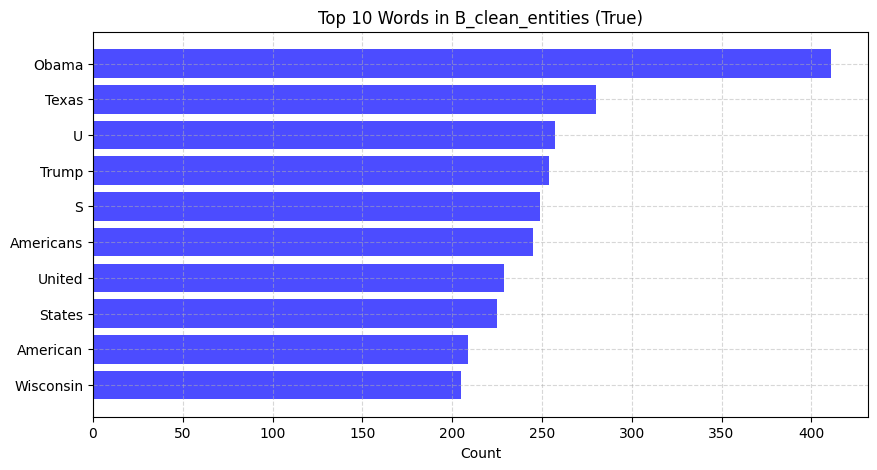

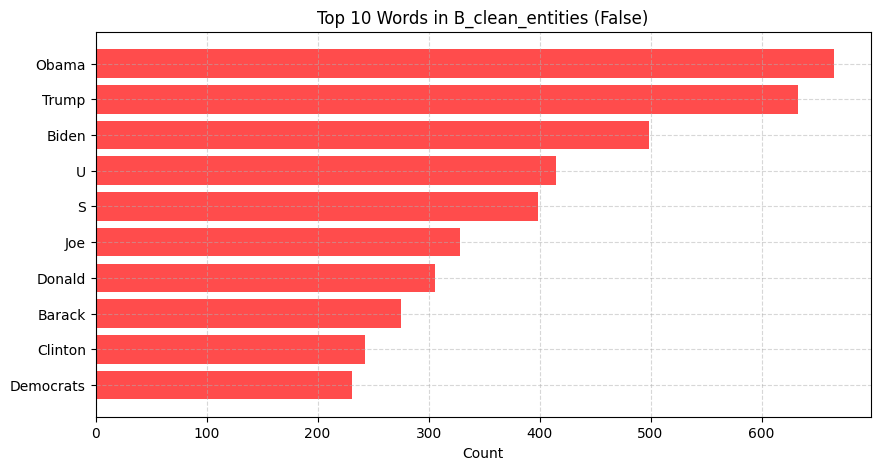

In [69]:
import matplotlib.pyplot as plt

def plot_top_words(results, title, color):
    """
    Plots a bar chart for the top 10 words.

    Parameters:
    - results (pd.DataFrame): Word count DataFrame.
    - title (str): Title for the plot.
    - color (str): Bar color.
    """
    top_results = results.head(10)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(top_results['word'], top_results['count'], color=color, alpha=0.7)

    ax.set_xlabel("Count")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.5)

    # Flip y-axis so most frequent words appear at the top
    ax.invert_yaxis()
    plt.show()

# Plot for A_clean_entities
plot_top_words(A_true_results, "Top 10 Words in A_clean_entities (True)", "blue")
plot_top_words(A_false_results, "Top 10 Words in A_clean_entities (False)", "red")

# Plot for B_clean_entities
plot_top_words(B_true_results, "Top 10 Words in B_clean_entities (True)", "blue")
plot_top_words(B_false_results, "Top 10 Words in B_clean_entities (False)", "red")